# Periscope + Sagemaker
Hello! Welcome to Periscope + Sagemaker!

## Introduction
In this demo, we will be using the XGBoost library on Sagemaker to predict the lifetime revenue of Toto customers. If you are new to Jupyter notebooks, just press the Run button at the top to run a code block.

## Getting Started
Let's start by specifying:

* The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.

* The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

**Note:** This notebook was created and tested on an ml.t2.medium notebook instance.

In [5]:
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

# bucket='sagemaker-periscopedata-demo-nyc'
# data_key = 'enhancedtotodataset.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

# set prefix for this instance
# please input your name in the following set of square brackets, making sure to use appropriate directory characters
prefix = 'sagemaker/[your-name-here]-xgboost-dm'

Now we'll import the Python libraries we'll need.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import os
import time
import json
import sagemaker.amazon.common as smac
import sagemaker
from sagemaker.predictor import csv_serializer, json_deserializer

## Data Import
Because Periscope has already brought the data into S3 as a CSV, importing it into a dataframe requires only a single line of Python. Here we bring the data in from S3 to a pandas dataframe and confirm the information by printing the top 5 records.

In [7]:
# read the csv from S3
df = pd.read_csv(data_location)

# display the first 5 records to verify the import
df.head(5)

,pair_id,lifetime_revenue,walk_count,dog_count,max_dog_size,min_dog_size,requester_gender,requester_fee,requester_new_to_rover,previous_client_count,price_per_walk,provider_fee,provider_gender,provider_new_to_rover,new_service_relationship,percent_morning_walks,percent_afternoon_walks,percent_evening_walks,experience
0,1,416.00,8,1,1,1,f,0.05,1,8,26,0.20,m,0,0,0.375000,0.375000,0.250000,requestor new
1,21,10564.40,49,1,4,4,m,0.05,0,9,22,0.15,f,0,0,0.326531,0.387755,0.285714,both experienced
2,48,2246.40,24,2,4,1,f,0.05,1,7,13,0.25,f,0,1,0.375000,0.333333,0.291667,requestor new
3,71,281.75,7,1,3,3,f,0.05,0,9,23,0.20,f,0,0,0.142857,0.571429,0.285714,both experienced
4,91,437.40,9,1,3,3,m,0.05,0,9,18,0.25,f,0,0,0.555556,0.222222,0.222222,both experienced


## Data Preparation
Most of the data preparation and feature engineering has already been performed in Periscope Data. There is one final step that is best done in Python: one-hot encoding the categorical variables. After importing the data from Periscope, this is the last step needed before running the training data through an ML model. 

In [8]:
# some of the categorical variables are currently encoded as numeric. The number of categories is low and can easily be one-hot encoded using get_dummy()

# categorical columns = max_dog_size, min_dog_size, requester_gender, provider_gender, experience
# continuous = walk_count, dog_count, requester_fee, previous_client_count, price_per_walk, provider_fee, percent_morning_walks, percent_afternoon_walks, percent_evening_walks
df = pd.get_dummies(df, columns = ["max_dog_size", "min_dog_size", "requester_gender", "provider_gender", "experience"])

#verify that the one-hot encoding (creation of boolean for each categorical variable) succeeded
df.head(5)

,pair_id,lifetime_revenue,walk_count,dog_count,requester_fee,requester_new_to_rover,previous_client_count,price_per_walk,provider_fee,provider_new_to_rover,...,min_dog_size_3,min_dog_size_4,requester_gender_f,requester_gender_m,provider_gender_f,provider_gender_m,experience_both experienced,experience_both new,experience_provider new,experience_requestor new
0,1,416.00,8,1,0.05,1,8,26,0.20,0,...,0,0,1,0,0,1,0,0,0,1
1,21,10564.40,49,1,0.05,0,9,22,0.15,0,...,0,1,0,1,1,0,1,0,0,0
2,48,2246.40,24,2,0.05,1,7,13,0.25,0,...,0,0,1,0,1,0,0,0,0,1
3,71,281.75,7,1,0.05,0,9,23,0.20,0,...,1,0,1,0,1,0,1,0,0,0
4,91,437.40,9,1,0.05,0,9,18,0.25,0,...,1,0,0,1,1,0,1,0,0,0


## Building Models

The most common way of preventing overfitting is to build models with the concept that a model shouldn't only be judged on its fit to the data it was trained on, but also on "new" data. There are several different ways of operationalizing this, holdout validation, cross-validation, leave-one-out validation, etc. For our purposes, we'll simply randomly split the data into 3 uneven groups. The model will be trained on 70% of data, it will then be evaluated on 20% of data to give us an estimate of the accuracy we hope to have on "new" data, and 10% will be held back as a final testing dataset which will be used later on.

In [9]:
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len(df)), int(0.9 * len(df))]) 

Amazon SageMaker's XGBoost container expects data in the libSVM or CSV data format. For this example, we'll stick to CSV. Note that the first column must be the target variable and the CSV should not include headers. Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before. This avoids any misalignment issues due to random reordering.

In [10]:
pd.concat([train_data['lifetime_revenue'], train_data.drop(['lifetime_revenue'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['lifetime_revenue'], validation_data.drop(['lifetime_revenue'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

Now we'll copy the file to S3 for Amazon SageMaker's managed training to pickup.

In [11]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

## Train
There are several intricacies to understanding the algorithm, but at a high level, gradient boosted trees works by combining predictions from many simple models, each of which tries to address the weaknesses of the previous models. By doing this the collection of simple models can actually outperform large, complex models. Other Amazon SageMaker notebooks elaborate on gradient boosting trees further and how they differ from similar algorithms.

xgboost is an extremely popular, open-source package for gradient boosted trees. It is computationally powerful, fully featured, and has been successfully used in many machine learning competitions. Let's start with a simple xgboost model, trained using Amazon SageMaker's managed, distributed training framework.

First we'll need to specify the ECR container location for Amazon SageMaker's implementation of XGBoost.

In [12]:
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest',
              'ap-northeast-1': '501404015308.dkr.ecr.ap-northeast-1.amazonaws.com/xgboost:latest',
              'ap-northeast-2': '306986355934.dkr.ecr.ap-northeast-2.amazonaws.com/xgboost:latest'}

Then, because we're training with the CSV file format, we'll create s3_inputs that our training function can use as a pointer to the files in S3, which also specify that the content type is CSV.

In [13]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

First we'll need to specify training parameters to the estimator. This includes:

1. The xgboost algorithm container
2. The IAM role to use
3. Training instance type and count
4. S3 location for output data
5. Algorithm hyperparameters
And then a .fit() function which specifies:

1. S3 location for output data. In this case we have both a training and validation set which are passed in.

In [14]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='reg:linear', # use linear regression to create a continuous output
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

INFO:sagemaker:Creating training-job with name: xgboost-2018-07-12-02-49-26-197


..................
Arguments: train
[2018-07-12:02:52:17:INFO] Running standalone xgboost training.
[2018-07-12:02:52:17:INFO] File size need to be processed in the node: 0.09mb. Available memory size in the node: 8594.78mb
[2018-07-12:02:52:17:INFO] Determined delimiter of CSV input is ','
[02:52:17] S3DistributionType set as FullyReplicated
[02:52:17] 700x29 matrix with 20300 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2018-07-12:02:52:17:INFO] Determined delimiter of CSV input is ','
[02:52:17] S3DistributionType set as FullyReplicated
[02:52:17] 200x29 matrix with 5800 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[02:52:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[0]#011train-rmse:4857.01#011validation-rmse:4915.15
[02:52:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[1]#011train-rm

===== Job Complete =====
Billable seconds: 89


## Hosting
Now that we've trained the xgboost algorithm on our data, let's deploy a model that's hosted behind a real-time endpoint.

In [15]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2018-07-12-02-52-38-070
INFO:sagemaker:Creating endpoint with name xgboost-2018-07-12-02-49-26-197


--------------------------------------------------------------!

## Evaluation
There are many ways to compare the performance of a machine learning model, but let's start by simply comparing actual to predicted values.

First we'll need to determine how we pass data into and receive data from our endpoint. Our data is currently stored as NumPy arrays in memory of our notebook instance. To send it in an HTTP POST request, we'll serialize it as a CSV string and then decode the resulting CSV.

_Note: For inference with CSV format, SageMaker XGBoost requires that the data does NOT include the target variable._

In [22]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

Now, we'll use a simple function to:

1. Loop over our test dataset
2. Split it into mini-batches of rows
3. Convert those mini-batches to CSV string payloads (notice, we drop the target variable from our dataset first)
4. Retrieve mini-batch predictions by invoking the XGBoost endpoint
5. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [23]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['lifetime_revenue'], axis=1).values)

# check the top 5 predictions to make sure they are reasonable
print(predictions[0:5])

[17069.9921875   2775.92041016  8452.59375       60.04449081
   619.32751465]


## RMSE 

The root mean square error helps us understand the difference between our predictions and the actual lifetime revenue. It aggregates the error/residuals in a way and helps us better evaluate the performance of our model. 

In [24]:
def rmse(predictions, actuals):
    rmse = ((predictions - actuals) ** 2).mean() ** .5
    return rmse

rmse(predictions = np.round(predictions), actuals = test_data['lifetime_revenue'])

1932.8565368029772

In this case, the RSME is $1932.86. Although this is a large number, it does make sense given the range of our dataset.

### Visualizing Predictions

Visualizing predictions is a helpful way to evaluate the efficacy of the model.

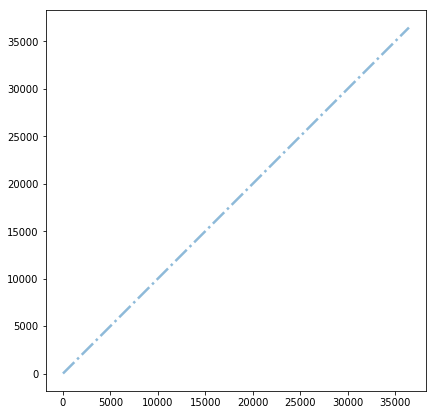

In [25]:
import seaborn as sns
from scipy import stats

plt.figure(figsize=(7,7))
plt.gca().set_aspect('equal', adjustable='box')
# plt.scatter(x = np.round(predictions),
#            y = test_data['lifetime_revenue'],
#            color = 'thistle')

max_lim = max(int(np.max(np.round(predictions))), int(np.max(test_data['lifetime_revenue'])))
x = np.linspace(0, max_lim, 10)
plt.plot(x, x, linewidth = 2.5, linestyle = '-.', alpha = 0.5)

#regression part
#sns.regplot(x=np.round(predictions), y=test_data['lifetime_revenue'], color = 'thistle')
plt.show()

Here, we see that predictions are more accurate in the lower ranges from 0 to \$150.00 since this is where we have the most data. For larger values and predictions, it becomes more difficult for the model to extrapolate. Looking at the graph, it appears that the model tends to overpredict for values over $150.00. Another graph that investigates this widening margin of error can be created with a simple linear regression model plot:

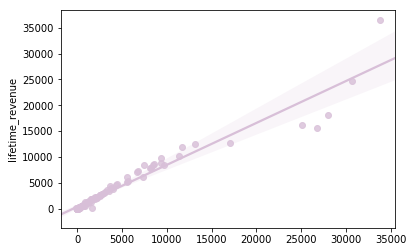

In [26]:
import seaborn as sns
sns.regplot(x=np.round(predictions), y=test_data['lifetime_revenue'], color = 'thistle')

## Extensions
This example analyzed a relatively small dataset, but utilized Amazon SageMaker features such as distributed, managed training and real-time model hosting, which could easily be applied to much larger problems. In order to improve predictive accuracy further, we could tweak value we threshold our predictions at to alter the mix of false-positives and false-negatives, or we could explore techniques like hyperparameter tuning. In a real-world scenario, we would also spend more time engineering features by hand and would likely look for additional datasets to include which contain additional information not available in our initial dataset.

### Clean-up
If you are done with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [27]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: xgboost-2018-07-12-02-49-26-197


ClientError: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "arn:aws:sagemaker:us-east-1:434811510200:endpoint/xgboost-2018-07-12-02-49-26-197".